# Price Prediction Notebook
This notebook connects to your MongoDB instance, extracts item stat data, and trains regression models to predict listing prices based on stat roll percentages.

In [10]:
# Install dependencies
!pip install pymongo pandas scikit-learn joblib matplotlib numpy


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Imports and document fetching

In [11]:

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from modules.db import get_collection
from modules.models.collection_types import Collection

docs = list(get_collection(Collection.MARKET_LISTINGS).find({"item_type": "GearItem", "unidentified": False}))
print(f"Fetched {len(docs)} documents.")

Fetched 2317 documents.


In [12]:
rows = []
for doc in docs:
    base = {
        'name': doc.get('name'),
        'listing_price': doc.get('listing_price', 0)
    }
    for stat in doc.get('stat_rolls', []):
        if stat.get('statRange', {}).get('fixed', False):
            continue
        key = f"stat_{stat['apiName']}"
        base[key] = stat.get('rollPercentage', 0)
    rows.append(base)

# Create DataFrame and fill missing stats with 0
df = pd.DataFrame(rows).fillna(0)
print(f"Dataframe shape after flattening: {df.shape}")

Dataframe shape after flattening: (2317, 80)


# Visualize Stat Roll Features

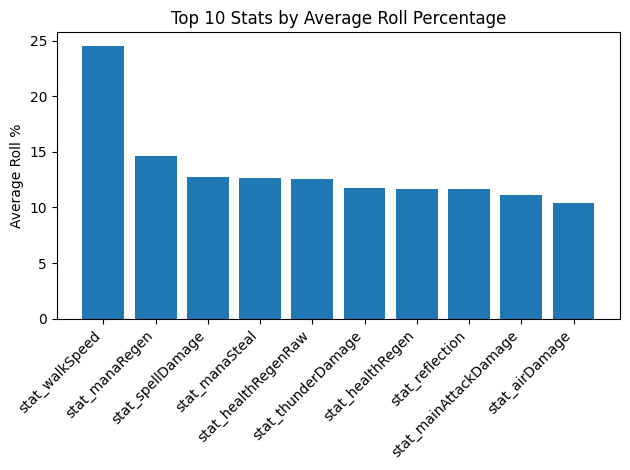

In [13]:
stat_cols = [c for c in df.columns if c.startswith('stat_')]
avg_rolls = df[stat_cols].mean().sort_values(ascending=False)

plt.figure()
top_n = 10
plt.bar(range(top_n), avg_rolls.head(top_n).values)
plt.xticks(range(top_n), avg_rolls.head(top_n).index, rotation=45, ha='right')
plt.ylabel('Average Roll %')
plt.title('Top 10 Stats by Average Roll Percentage')
plt.tight_layout()
plt.show()

# Calculate Stat Weights Per Item Name
We use Ridge regression on each item subset to get interpretable stat weights.

In [14]:
item_names = df['name'].unique()
weights_list = []
for name in item_names:
    sub = df[df['name'] == name]
    n_samples = len(sub)
    if n_samples < 2:
        continue
    # dynamic cross-validation folds
    cv_folds = min(5, n_samples)
    X_sub = sub[stat_cols]
    y_sub = sub['listing_price']
    # train on log-scale for stability
    y_log = np.log1p(y_sub)
    ridge = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=cv_folds, scoring='neg_mean_squared_error')
    ridge.fit(X_sub, y_log)
    # extract and normalize coefficients
    coef = pd.Series(ridge.coef_, index=stat_cols)
    # convert to percentage of total positive contribution
    total_pos = coef[coef > 0].sum()
    if total_pos == 0:
        continue  # no positive impacts
    pct = (coef.clip(lower=0) / total_pos * 100).round(2)
    # select top 3 positive-impact stats
    top_stats = pct.nlargest(3)
    entry = {'name': name}
    for i, (stat, weight) in enumerate(top_stats.items(), start=1):
        entry[f'stat{i}']       = stat
        entry[f'weight{i}_pct'] = weight
    weights_list.append(entry)

# Build summary DataFrame with ordered columns
summary_cols = []
for i in range(1, 4):
    summary_cols += [f'stat{i}', f'weight{i}_pct']
top_stats_df = pd.DataFrame(weights_list).set_index('name')[summary_cols]

# Save and display results
top_stats_df.to_csv('top3_positive_stat_weights_per_item.csv')
print('Saved positive-impact top-3 stat weights per item to top3_positive_stat_weights_per_item.csv')
# Display the summary table for interactive viewing
top_stats_df

Saved positive-impact top-3 stat weights per item to top3_positive_stat_weights_per_item.csv


,stat1,weight1_pct,stat2,weight2_pct,stat3,weight3_pct
name,,,,,,
Morph-Stardust,stat_walkSpeed,85.94,stat_healthRegenRaw,14.06,stat_manaRegen,0.00
Misalignment,stat_waterDamage,100.00,stat_manaRegen,0.00,stat_healthRegenRaw,0.00
Revenant,stat_airDamage,28.31,stat_mainAttackDamage,14.78,stat_reflection,12.96
Dark Matter,stat_rawElementalSpellDamage,33.21,stat_rawNeutralDamage,26.45,stat_spellDamage,18.96
Taurus,stat_mainAttackDamage,78.04,stat_exploding,21.96,stat_manaRegen,0.00
...,...,...,...,...,...,...
Wybel Carved Relik,stat_xpBonus,51.70,stat_lootBonus,27.62,stat_rawHealth,20.68
Crusade Sabatons,stat_thorns,45.50,stat_walkSpeed,36.48,stat_healthRegen,17.82
Etiolation,stat_rawDamage,29.73,stat_manaSteal,26.38,stat_damage,22.75


# Global Benchmark Models
Below we train global models on all items combined for comparison.

In [15]:
X = df[stat_cols]
y = df['listing_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ridge_glob = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5, scoring='neg_mean_squared_error').fit(X_train, y_train)
pred_ridge = ridge_glob.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, pred_ridge))
r2_ridge = r2_score(y_test, pred_ridge)
print(f"Global Ridge RMSE: {rmse_ridge:.2f}, R^2: {r2_ridge:.3f}")

rf_glob = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
pred_rf = rf_glob.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
r2_rf = r2_score(y_test, pred_rf)
print(f"Global RF RMSE: {rmse_rf:.2f}, R^2: {r2_rf:.3f}")

# Save best global model
to_save = rf_glob if r2_rf > r2_ridge else ridge_glob
joblib.dump(to_save, 'best_global_price_model.pkl')
print("Saved best global model to 'best_global_price_model.pkl'")

Global Ridge RMSE: 3211307.81, R^2: 0.083
Global RF RMSE: 2750411.70, R^2: 0.327
Saved best global model to 'best_global_price_model.pkl'


# Testing Models
Below are steps to evaluate model performance and visualize predictions.

Global Model Performance: RMSE: 2750411.70 MAE :  704984.136392 R^2 : 0.327


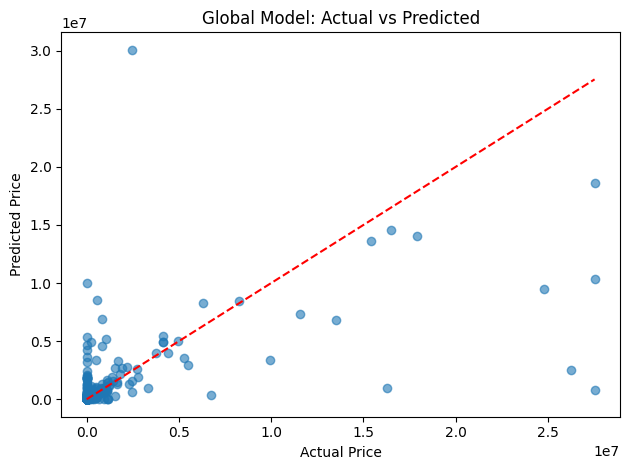

In [16]:
from sklearn.metrics import mean_absolute_error

# Load global model and test metrics
global_model = joblib.load('best_global_price_model.pkl')
y_pred_global = global_model.predict(X_test)
rmse_global = np.sqrt(mean_squared_error(y_test, y_pred_global))
mae_global = mean_absolute_error(y_test, y_pred_global)
r2_global = r2_score(y_test, y_pred_global)
print(f"Global Model Performance: RMSE: {rmse_global:.2f} MAE : {mae_global: 2f} R^2 : {r2_global:.3f}")

# Scatter plot of actual vs predicted
plt.figure()
plt.scatter(y_test, y_pred_global, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Global Model: Actual vs Predicted')
plt.tight_layout()
plt.show()

# Real-World Testing with New Examples
Use a separate set of 'real' items (e.g., held-out collection or manually curated JSON/CSV) to evaluate model predictions. Below is a template for loading and predicting on such data:

In [17]:
import os
import json
from pandas import json_normalize
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) Load MongoDB JSON export
to_test = 'wynnventory.trademarket_listings.json'  # path to your JSON file
with open(to_test, 'r') as f:
    data = json.load(f)

# 2) Normalize stat_rolls into flat rows
df_stats = json_normalize(
    data,
    record_path='stat_rolls',
    meta=['name', 'listing_price'],
    errors='ignore'
)
# 3) Exclude fixed stat rolls
df_stats = df_stats[df_stats['statRange.fixed'] == False]

# 4) Pivot so each stat apiName becomes a column with rollPercentage
df_pivot = df_stats.pivot_table(
    index=['name', 'listing_price'],
    columns='apiName',
    values='rollPercentage',
    aggfunc='first'
).reset_index()
# 5) Prefix stat_ and fill missing values with 0
df_pivot.columns.name = None
df_pivot = df_pivot.rename(columns=lambda c: f'stat_{c}' if c not in ['name','listing_price'] else c)
# 5.1) Fill NaN for all stat_* columns
stat_cols_in_pivot = [col for col in df_pivot.columns if col.startswith('stat_')]
df_pivot[stat_cols_in_pivot] = df_pivot[stat_cols_in_pivot].fillna(0)

# 6) Ensure all model stat_cols are present Ensure all model stat_cols are present
for col in stat_cols:
    if col not in df_pivot:
        df_pivot[col] = 0

# 7) Reorder to match training features
new_df = df_pivot[['name', 'listing_price'] + stat_cols]
# Ensure new_df is a standalone copy before adding new columns (avoids SettingWithCopyWarning)
new_df = new_df.copy()

# 8) Predict and evaluate — per-item or global predictions
# Load global model for fallback
global_model = joblib.load('best_global_price_model.pkl')

# Predict using per-item models when available
preds = []
for _, row in new_df.iterrows():
    name = row['name']
    item_model_path = f"model_{name}.pkl"
    if os.path.exists(item_model_path):
        m = joblib.load(item_model_path)
    else:
        m = global_model
    # Use DataFrame row to preserve feature names
    X_row = row[stat_cols].to_frame().T
    preds.append(m.predict(X_row)[0])

new_df['predicted_price'] = preds

# Compute evaluation metrics
rmse = np.sqrt(mean_squared_error(new_df['listing_price'], new_df['predicted_price']))
mae = mean_absolute_error(new_df['listing_price'], new_df['predicted_price'])
r2 = r2_score(new_df['listing_price'], new_df['predicted_price'])
print(f"JSON Export Performance: RMSE: {rmse:.2f} MAE : {mae:.2f} R² : {r2:.3f}")

# Preview results per item: display separate tables for each item name
from IPython.display import display, Markdown

for name in new_df['name'].unique():
    item_df = new_df[new_df['name'] == name].copy()
    # Determine non-zero stat columns for this item
    nonzero_stats = [col for col in stat_cols if item_df[col].any() and not (item_df[col] == 0).all()]
    # Build ordered columns: name, actual, predicted, then nonzero stats
    cols = ['name', 'listing_price', 'predicted_price'] + nonzero_stats
    table = item_df[cols].reset_index(drop=True)
    display(Markdown(f"### Item: {name} (n={len(item_df)})"))
    display(table)

# Plot actual vs predicted for all items
plt.figure()
plt.scatter(new_df['listing_price'], new_df['predicted_price'], alpha=0.6)
plt.plot(
    [new_df['listing_price'].min(), new_df['listing_price'].max()],
    [new_df['listing_price'].min(), new_df['listing_price'].max()], 'r--'
)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Model Predictions on JSON Export')
plt.tight_layout()
plt.show()


C:\Users\timki\AppData\Local\Temp\ipykernel_42824\2965519030.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pivot[stat_cols_in_pivot] = df_pivot[stat_cols_in_pivot].fillna(0)


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- stat_airMainAttackDamage
- stat_neutralMainAttackDamage
- stat_neutralSpellDamage
- stat_rawEarthDamage
- stat_rawNeutralMainAttackDamage
- ...
